In [4]:
%matplotlib notebook
# https://stackoverflow.com/questions/43599018/is-there-a-way-to-get-matplotlib-path-contains-points-to-be-inclusive-of-boundar
#I do quite like this command in Jupiter notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
#It makes things wider and not waste the space on your screen
import pandas as pd
import importlib
import csv,os
import numpy as np
import pandas as pd
import itertools
import pyproj
import shapely
import copy
from uafgi import gicollections,cfutil,glacier,gdalutil,shputil,pdutil
import uafgi.data.ns642
import netCDF4
import matplotlib.pyplot as plt
import uafgi.data.wkt
import uafgi.data.w21 as d_w21
map_wkt = uafgi.data.wkt.nsidc_ps_north
pd.set_option("display.max_rows", 30, "display.max_columns", None)
pd.set_option("display.max_rows", 200, "display.max_columns", None)

In [5]:
# For now, do this for just 1 glacier
w21_glacier_id = 199   # Sverdrup
select = pdutil.ExtDf.read_pickle(uafgi.data.join_outputs('stability/01_select.dfx'))
select.df.columns

Index(['w21t_Glacier', 'w21t_date_termini', 'w21t_glacier_number', 'w21t_tloc',
       'w21_popular_name', 'w21_greenlandic_name', 'w21_coast', 'w21_category',
       'w21_Qr', 'w21_Qf', 'w21_Qm', 'w21_Qs', 'w21_Qc_inferred', 'w21_qm',
       'w21_qf', 'w21_qc', 'w21_mean_depth', 'w21_min_depth',
       'w21_quality_str', 'w21_area_grounded_1992_2017',
       'w21_area_grounded_1992_1997', 'w21_area_grounded_1998_2007',
       'w21_area_grounded_2008_2017', 'w21_mean_fjord_width',
       'w21_length_grounded_1992_2017', 'w21_length_grounded_1992_1997',
       'w21_length_grounded_1998_2007', 'w21_length_grounded_2008_2017',
       'w21_ocean_model_sample_area', 'w21_mean_TF_1992-2017',
       'w21_mean_TF_1992-1997', 'w21_mean_TF_1998-2007',
       'w21_mean_TF_2008-2017', 'w21_subglacial_discharge_1992_2017',
       'w21_subglacial_discharge_1992_1997',
       'w21_subglacial_discharge_1998_2007',
       'w21_subglacial_discharge_2008_2017', 'w21_mean_xsection_area',
       'w21_mean_

In [10]:
selrow = select.df.set_index('w21t_glacier_number').loc[w21_glacier_id]
selrow

w21t_Glacier                                                     Sverdrup
w21t_date_termini       [(2009-06-15 00:00:00, LINESTRING (-360238.412...
w21t_tloc                   POINT (-359324.3045170318 -1530658.529749425)
w21_popular_name                                             Sverdrup Gl.
w21_greenlandic_name                                                     
                                              ...                        
cf20_allnames           (, Sverdrup Gletsjer, Sverdrup Brae, Sverdrup ...
ns642_key                                                            46.0
ns642_GlacierID                                                      46.0
ns642_date_termini      [((2000-09-30 00:00:00, 2001-01-23 00:00:00), ...
ns642_points            (POINT (-362282.5089562261 -1529051.32541127),...
Name: 199, Length: 74, dtype: object

In [11]:
selrow.w21_data_fname

'Sverdrup Data.nc'

In [56]:
tpl = uafgi.data.join_outputs('wood2021', 'velocities', 'vel_{}_2011_2020').format(selrow.ns481_grid)
velocity_file = tpl+'.nc'
sigma_file = tpl+'_sigma.nc'
bedmachine_file = uafgi.data.join_outputs('bedmachine', 'BedMachineGreenland-2017-09-20_{}.nc'.format(selrow.ns481_grid))
sigma_file

'outputs/wood2021/velocities/vel_W75.50N_2011_2020_sigma.nc'

[datetime.datetime(2010, 12, 30, 0, 0)
 datetime.datetime(2011, 12, 31, 0, 0)
 datetime.datetime(2012, 12, 30, 0, 0)
 datetime.datetime(2013, 12, 30, 0, 0)
 datetime.datetime(2014, 12, 30, 0, 0)
 datetime.datetime(2015, 12, 31, 0, 0)
 datetime.datetime(2016, 12, 30, 0, 0)]
[[datetime.datetime(2010, 7, 1, 0, 0) datetime.datetime(2011, 7, 1, 0, 0)]
 [datetime.datetime(2011, 7, 1, 0, 0) datetime.datetime(2012, 7, 1, 0, 0)]
 [datetime.datetime(2012, 7, 1, 0, 0) datetime.datetime(2013, 7, 1, 0, 0)]
 [datetime.datetime(2013, 7, 1, 0, 0) datetime.datetime(2014, 7, 1, 0, 0)]
 [datetime.datetime(2014, 7, 1, 0, 0) datetime.datetime(2015, 7, 1, 0, 0)]
 [datetime.datetime(2015, 7, 1, 0, 0) datetime.datetime(2016, 7, 1, 0, 0)]
 [datetime.datetime(2016, 7, 1, 0, 0) datetime.datetime(2017, 7, 1, 0, 0)]]


In [35]:
date_termini = selrow.w21t_date_termini

In [44]:
#importlib.reload(cfutil)
# Get velocity times
print('sigma_file ', sigma_file)
with netCDF4.Dataset(velocity_file) as nc:
    ntimes = len(nc.dimensions['time'])
    print('ntimes = {}'.format(ntimes))
    print(nc.variables['time'][:])
    times = cfutil.read_time(nc, 'time')
    time_bndss = cfutil.read_time(nc, 'time_bnds', unitvar='time')

# Get available terminus locations


sigma_file  outputs/wood2021/velocities/vel_W75.50N_2011_2020_sigma.nc
ntimes = 7
[   0.  366.  731. 1096. 1461. 1827. 2192.]


In [ ]:
from uafgi.pism import flow_simulation
importlib.reload(flow_simulation)
itime = 0
#termini = [date_termini[0][1]]

date_termini.sort()
termini = [terminus for _,terminus in date_termini]
frs = flow_simulation.flow_rate3(selrow['ns481_grid'],
    bedmachine_file, selrow['fj_poly'],
    velocity_file,sigma_file,itime, termini,
    selrow['up_loc'])

NameError: name 'fluxdf' is not defined

In [3]:
import scipy.interpolate
from uafgi import dtutil
data = list()
for (date,terminus),fr in zip(date_termini,frs):
    data.append((date,terminus,fr.aflux,fr.sflux,fr.up_area))
#    print(date, fr.sflux/fr.aflux, fr)
fluxdf = pd.DataFrame(data, columns=('date','terminus','aflux','sflux','up_area'))
fluxdf['fluxratio'] = fluxdf.sflux/fluxdf.aflux
fluxdf['year'] = fluxdf['date'].map(dtutil.year_fraction)   # [a]

NameError: name 'date_termini' is not defined

<IPython.core.display.Javascript object>


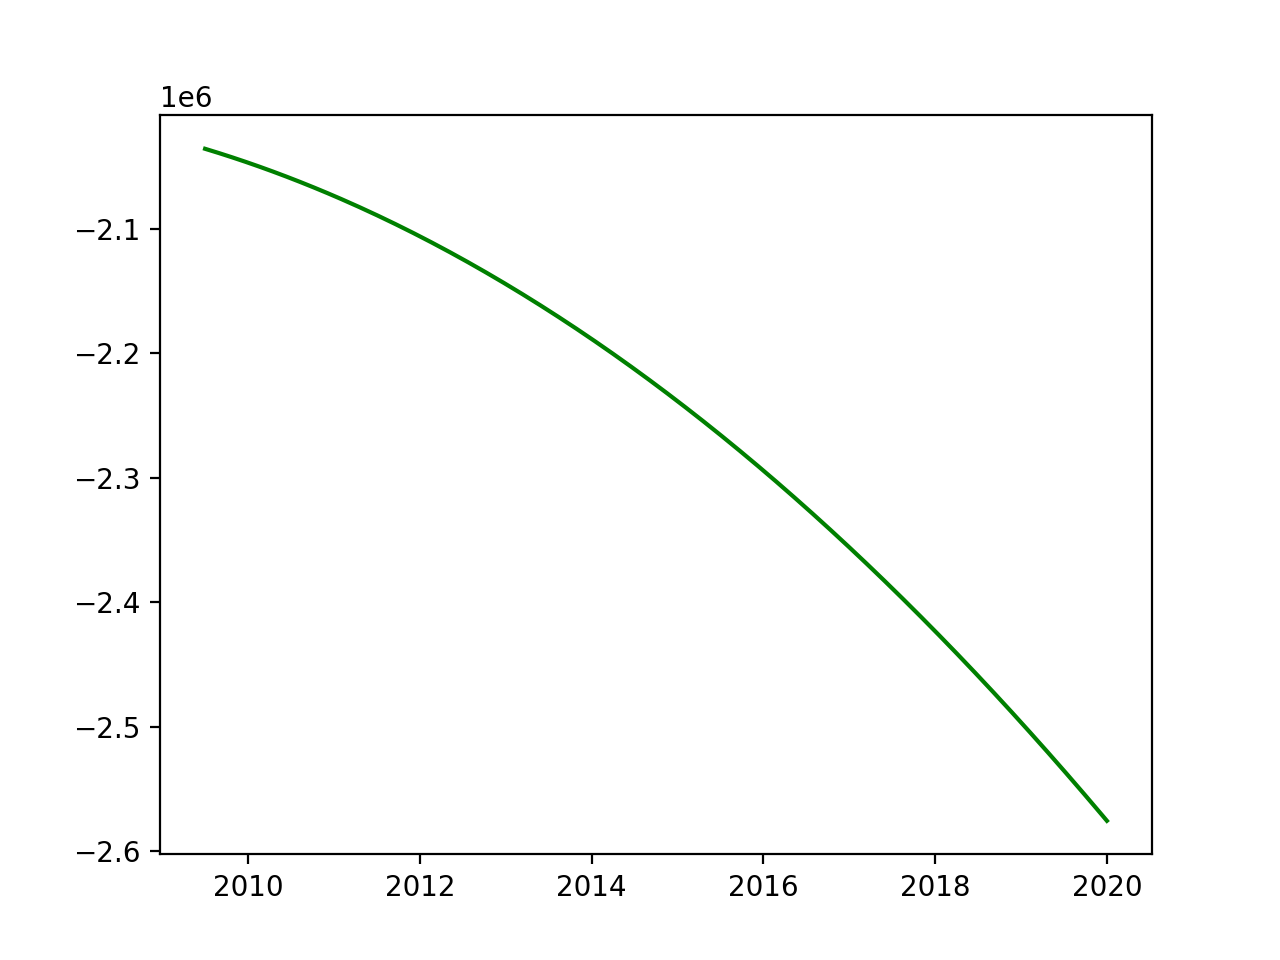

In [125]:
spl = scipy.interpolate.UnivariateSpline(fluxdf['year'], fluxdf['up_area'], s=5e14)
#spl.set_smoothing_factor(.001)
#xs = np.linspace(1985,2020,200)
xs = np.linspace(2009.5,2020,200)
plt.plot(xs,spl.derivative()(xs), 'g')
plt.show()

<IPython.core.display.Javascript object>


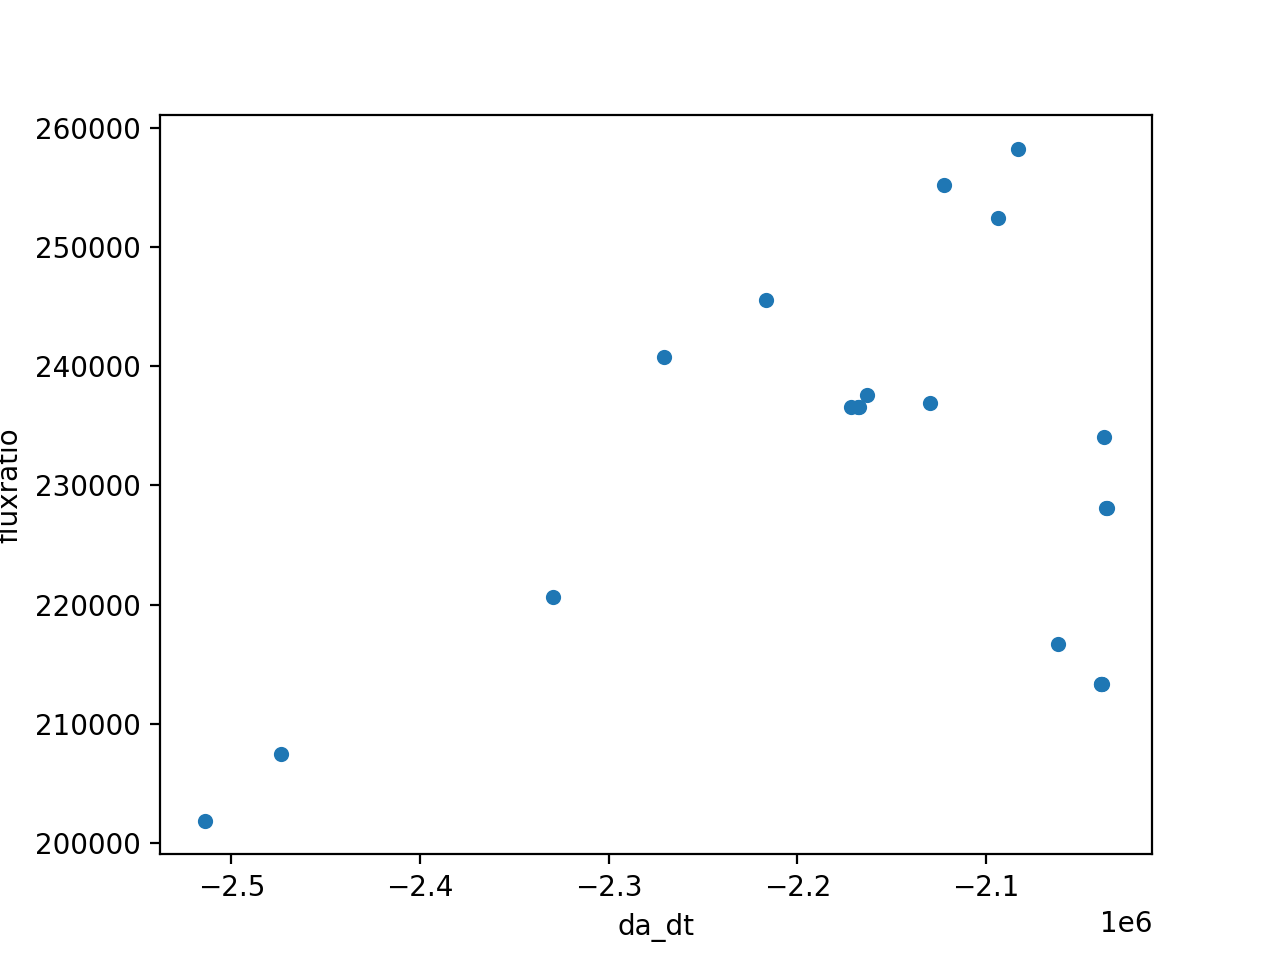

,date,terminus,aflux,sflux,up_area,fluxratio,year,da_dt
147,2009-07-10,LINESTRING (-360238.412322245 -1526975.9151200...,0.069162,15774.535471,175330000.0,228079.824083,2009.520434,-2.035895e+06
148,2009-07-17,"LINESTRING (-360201.84586165 -1526913.1609995,...",0.069162,15774.535471,175570000.0,228079.824083,2009.539612,-2.036299e+06
149,2009-08-09,LINESTRING (-358605.27012455 -1526104.67267784...,0.064234,15034.521711,170810000.0,234056.960184,2009.602626,-2.037639e+06
150,2009-08-27,"LINESTRING (-359284.432416304 -1526453.693744,...",0.084420,18010.179241,169500000.0,213339.128938,2009.651941,-2.038705e+06
151,2009-09-01,"LINESTRING (-359284.432416304 -1526453.693744,...",0.084420,18010.179241,169500000.0,213339.128938,2009.665639,-2.039003e+06
152,2009-09-03,"LINESTRING (-359284.432416304 -1526453.693744,...",0.084420,18010.179241,169500000.0,213339.128938,2009.671119,-2.039123e+06
153,2010-08-03,LINESTRING (-359260.400006599 -1526388.2670775...,0.092360,20016.915323,171220000.0,216726.113743,2010.586187,-2.061568e+06
154,2011-04-27,LINESTRING (-360098.511025584 -1526693.3047254...,0.096758,24984.957903,167860000.0,258221.280142,2011.317694,-2.083019e+06
155,2011-08-24,LINESTRING (-358472.105860763 -1526122.9920202...,0.098309,24815.394399,166480000.0,252421.498498,2011.643721,-2.093584e+06
156,2012-06-12,LINESTRING (-358447.041011505 -1526128.3372101...,0.099789,25467.456357,168700000.0,255211.854441,2012.445241,-2.122192e+06


In [127]:
spld = spl.derivative()

# Select only newer rows since delcine started
fluxdf = fluxdf[fluxdf['year'] >= 2009.5]

#fluxdf['da_dt'] = fluxdf['up_area'].diff() / fluxdf['year'].diff()
fluxdf['da_dt'] = fluxdf['year'].map(spld)
fluxdf.plot.scatter(x='da_dt', y='fluxratio')
fluxdf

<IPython.core.display.Javascript object>


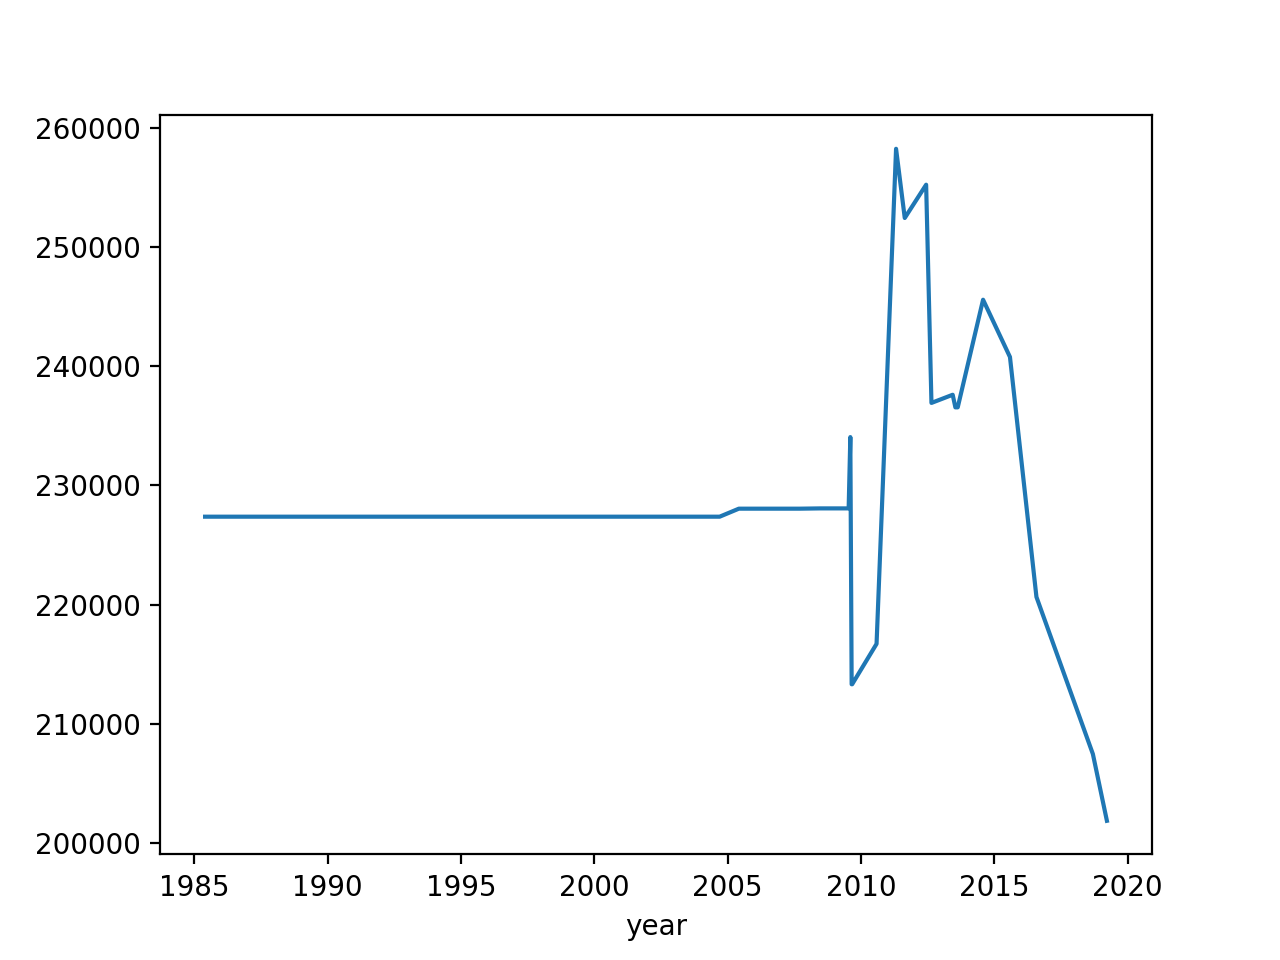

In [126]:
fluxdf.set_index('year')['fluxratio'].plot()
plt.show()